In [36]:
!pip install seaborn

     |████████████████████████████████| 292 kB 4.9 MB/s eta 0:00:01
You should consider upgrading via the '/home/ecbm4040/envTF24/bin/python3 -m pip install --upgrade pip' command.


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split
import re
import tensorflow as tf

In [25]:
data_path  = "/home/ecbm4040/preprocessed_data.csv"
df1 = pd.read_csv(data_path,names=['text','job_category'],encoding = "ISO-8859-1")
df2 = pd.read_csv('/home/ecbm4040/jobspikr.csv',names=['text','job_category'],encoding = "ISO-8859-1")
df3 = pd.read_csv('/home/ecbm4040/_20191023_1.csv',names=['text','job_category'],encoding = "ISO-8859-1")

In [50]:
df=pd.concat([df1,df2, df3], ignore_index = True,axis=0)
d = {'job_category':df['job_category'].value_counts().index, 'count': df['job_category'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)
df['cat_id'] = df['job_category'].factorize()[0]
cat_id_df = df[['job_category', 'cat_id']].drop_duplicates().sort_values('cat_id').reset_index(drop=True)
cat_to_id = dict(cat_id_df.values)
id_to_cat = dict(cat_id_df[['cat_id', 'job_category']].values)

In [27]:
MAX_NB_WORDS = 500
# Biggest leagth
MAX_SEQUENCE_LENGTH = 250
# Embeddingceng Vector
EMBEDDING_DIM = 100
 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index


In [28]:
X = tokenizer.texts_to_sequences(df['text'].values)
#padding x
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
 
#coding labels
Y = pd.get_dummies(df['cat_id']).values
 
print(X.shape)
print(Y.shape)

(9984, 250)
(9984, 27)


In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6988, 250) (6988, 27)
(2996, 250) (2996, 27)


In [30]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(tf.keras.layers.LSTM(50, dropout=0.2,return_sequences=True, recurrent_dropout=0.2))
model.add(tf.keras.layers.LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(tf.keras.layers.Dense(27, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          50000     
_________________________________________________________________
lstm_6 (LSTM)                (None, 250, 50)           30200     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 27)                1377      
Total params: 101,777
Trainable params: 101,777
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/10
99/99 [==============================] - 65s 624ms/step - loss: 1.9016 - accuracy: 0.5755 - val_loss: 0.8143 - val_accuracy: 0.6166
Epoch 2/10
99/99 [==============================] - 61s 621ms/step - loss: 0.8181 - accuracy: 0.6213 - val_loss: 0.8048 - val_accuracy: 0.6109
Epoch 3/10
99/99 [==============================] - 60s 611ms/step - loss: 0.8155 - accuracy: 0.6225 - val_loss: 0.7635 - val_accuracy: 0.6137
Epoch 4/10
99/99 [==============================] - 61s 618ms/step - loss: 0.7673 - accuracy: 0.6428 - val_loss: 0.5983 - val_accuracy: 0.7639
Epoch 5/10
99/99 [==============================] - 64s 644ms/step - loss: 0.6746 - accuracy: 0.7235 - val_loss: 0.4635 - val_accuracy: 0.8569
Epoch 6/10
99/99 [==============================] - 60s 611ms/step - loss: 0.4475 - accuracy: 0.8519 - val_loss: 0.3456 - val_accuracy: 0.8984
Epoch 7/10
99/99 [==============================] - 61s 616ms/step - loss: 0.3822 - accuracy: 0.8864 - val_loss: 0.3176 - val_accuracy: 0.9113

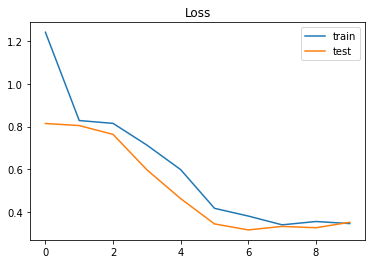

In [32]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

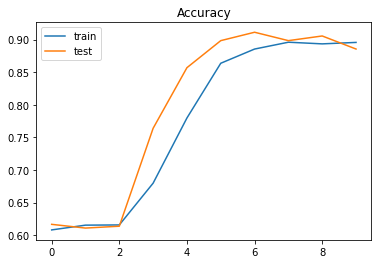

In [33]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [52]:
d = {'cat':df['job_category'].value_counts().index, 'count': df['job_category'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)

In [55]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
 
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis = 1)
Y_test = Y_test.argmax(axis = 1)

In [52]:
def predict(text):
    seq = tokenizer.texts_to_sequences(text)
    padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    cat_id= pred.argmax(axis=1)[0]
    return cat_id_df[cat_id_df.cat_id==cat_id]['job_category'].values[0]


In [50]:
predict('Making the right decision is a difficult but interesting thing, you must calculate the outcome of each choice and calculate the impact of each outcome. After I took the course of probability theory and statistics in college, I became fascinating in decision making methods. This passion carried me through my education at PKU. I studied new languages including SQL')

'data scientist'

In [53]:
predict('Currently I am mainly working on back-end, such as micro-service, automated workflow and event processing pipeline, but I also have experience in deploying infrastructure as code and front-end development.')

'software design'

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

hidden_features = model.predict(X)
pca = PCA(n_components=27)
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
##Variance PCA: 0.993621154832802

#Run T-SNE on the PCA features.
tsne = TSNE(n_components=3, verbose = 1)
tsne_results = tsne.fit_transform(pca_result[:5000])

Variance PCA: 1.0
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 0.620s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.702145
[t-SNE] KL divergence after 1000 iterations: 0.193630


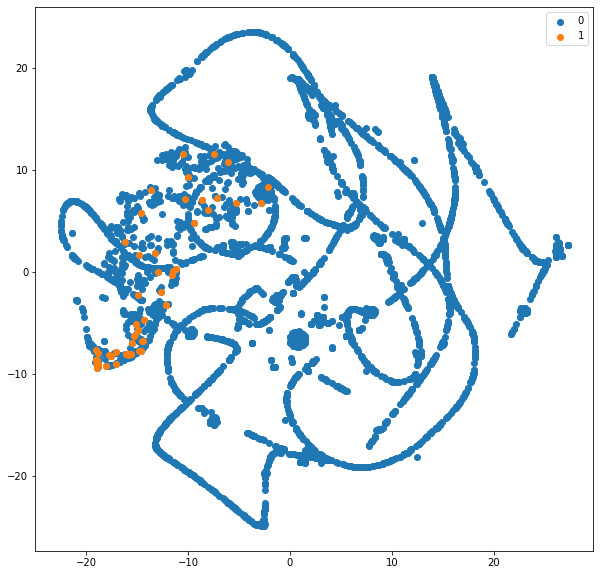

In [15]:
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

y_test_cat = to_categorical(Y[:5000], num_classes = 2)
color_map = np.argmax(y_test_cat, axis=1)
plt.figure(figsize=(10,10))
for cl in range(2):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl)
plt.legend()
plt.show()